In [1]:
import sys
import os
os.listdir("..")

['vgg.py',
 'store.png',
 'in.png',
 'out.png',
 'content.png',
 '__pycache__',
 'inspo',
 '.gitignore',
 'scripts',
 'losses.py',
 '.ipynb_checkpoints',
 '.git',
 'style.png']

In [2]:
sys.path.append('..')
from losses import *
from vgg import VGG

In [3]:
import torch
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import requests
from io import BytesIO

import matplotlib.pyplot as plt
def display_image(tensor):
    plt.imshow(tensor.squeeze().permute(1, 2, 0)  )

def size_to_fit(size, max_dim, scale_up=False):
    w, h = size
    if not scale_up and max(h, w) <= max_dim:
        return w, h
    new_w, new_h = max_dim, max_dim
    if h > w:
        new_w = round(max_dim * w / h)
    else:
        new_h = round(max_dim * h / w)
    return new_w, new_h


# Function to load and preprocess the image
def load_image(url, size=224):
    response = requests.get(url)
    image = Image.open(BytesIO(response.content))

    # Transformation: Resize and center crop
    transform = transforms.Compose([
        transforms.Resize(size),  # Resize so the smaller side is size
        transforms.CenterCrop(size),  # Center crop to the desired size
        transforms.ToTensor(),  # Convert the PIL Image to a tensor
    ])

    image = transform(image).unsqueeze(0)  # Add a batch dimension
    return image


# Instantiate the VGG class (for example, extracting features from layers 3, 8, 17, and 26)


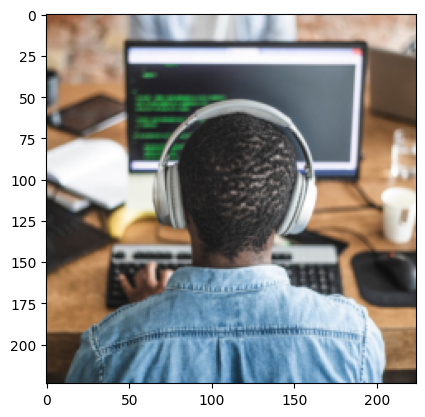

In [4]:
content_url = "https://static1.smartbear.co/smartbearbrand/media/images/home/sb-hero-bg-img.jpg"
content_image = load_image(content_url)
display_image(content_image)

In [5]:
content_image.shape

torch.Size([1, 3, 224, 224])

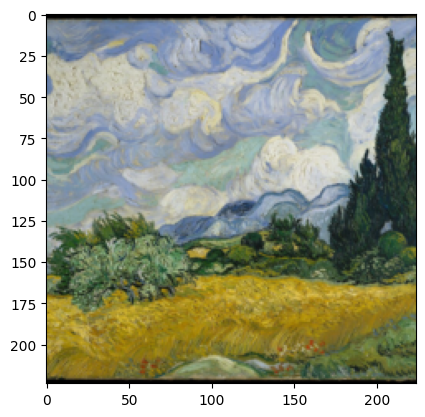

In [6]:
style_url = "https://collectionapi.metmuseum.org/api/collection/v1/iiif/436535/796067/main-image"
style_image = load_image(style_url)
display_image(style_image)

Getting the optimization targets

In [7]:
content_layers = [22]
content_weights = [350] 

style_layers = [1, 6, 11, 20, 29]
style_weights = [256, 64, 16, 4, 1]
layers = style_layers + content_layers

vgg = VGG(layers=style_layers + content_layers)


style_features = vgg(style_image, style_layers)
style_targets = []
for i in style_features.keys():
    print(i)
    style_targets.append(GramMatrix()(style_features[i]).detach())

content_features = vgg(content_image, content_layers)
content_targets = []
for i in content_features.keys():
    content_targets.append(content_features[i].detach())


/opt/homebrew/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


1
6
11
20
29


In [8]:
style_targets[0].shape

torch.Size([1, 64, 64])

In [9]:
content_targets[0].shape

torch.Size([1, 512, 28, 28])

In [10]:

temp = StyleLoss(style_targets[0])

In [11]:
temp.target

tensor([[[2.3526e-06, 1.1963e-05, 0.0000e+00,  ..., 0.0000e+00,
          9.5865e-06, 1.6031e-05],
         [1.1963e-05, 2.3204e-03, 0.0000e+00,  ..., 2.7969e-05,
          1.3653e-03, 2.2915e-03],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         ...,
         [0.0000e+00, 2.7969e-05, 0.0000e+00,  ..., 1.1488e-05,
          3.1374e-05, 4.3491e-05],
         [9.5865e-06, 1.3653e-03, 0.0000e+00,  ..., 3.1374e-05,
          1.4388e-03, 1.8142e-03],
         [1.6031e-05, 2.2915e-03, 0.0000e+00,  ..., 4.3491e-05,
          1.8142e-03, 3.1694e-03]]])

In [12]:
loss_fns = []
for style_target in style_targets:
    loss_fns.append(StyleLoss(style_target))
for content_target in content_targets:
    loss_fns.append(ContentLoss(content_target))


In [13]:
[type(f) for f in loss_fns]

[losses.StyleLoss,
 losses.StyleLoss,
 losses.StyleLoss,
 losses.StyleLoss,
 losses.StyleLoss,
 losses.ContentLoss]

In [30]:

from tqdm import tqdm
output_image = content_image.detach().clone()
output_image.requires_grad_(True)
style_weights = [1e3/n**2 for n in [64,128,256,512,512]]
content_weights = [1e0]
weights = style_weights  + content_weights
from torch import optim
losses = []
images = []
opt = optim.Adam([output_image], lr=5/255)
for i in tqdm(range(500)):
#     print(i)
    if (i%100==0):
        images.append(output_image.clone().detach())
#         display_image(output_image.clone().detach()
    features = vgg(output_image)

    loss = torch.tensor(0.)

    x = 0
    style_loss_tot = 0
    for layer in style_layers:
        current_features = GramMatrix()(features[layer])
        style_lossnow = weights[x] * loss_fns[x](current_features, features[layer])
        style_loss_tot += style_lossnow
        loss = loss +style_lossnow
        x += 1
        
    print(style_loss_tot.item())
#     x = len(style_layers)
    content_loss_tot = 0
    for layer in content_layers:
        current_features = features[layer]
        content_lossnow = weights[x] * loss_fns[x](current_features)
        print(content_lossnow.item())
        print(content_lossnow)
        loss = loss +  content_lossnow 
        content_loss_tot = content_lossnow
    
#         x += 1
#     print(content_loss_tot.item())
        
#     tv = TVLoss()(output_image)
# #     print(tv.item())
#     loss = loss + tv
#     print(f"x {loss.item()}")
    
        
    opt.zero_grad()
#     losses.append(loss.item())

    loss.backward()

    opt.step()
#     print(f"Loss {loss.item()}")
    with torch.no_grad():
        output_image.clamp_(0, 1)


  0%|                                                   | 0/500 [00:00<?, ?it/s]

1.766492854771151e-11
0.0
tensor(0., grad_fn=<MulBackward0>)


  0%|                                           | 1/500 [00:00<06:03,  1.37it/s]

1.7664820994856e-11
1.7280286556342617e-05
tensor(1.7280e-05, grad_fn=<MulBackward0>)


  0%|▏                                          | 2/500 [00:01<04:40,  1.78it/s]

3.5948355403547794e-11
416549.8125
tensor(416549.8125, grad_fn=<MulBackward0>)


  1%|▎                                          | 3/500 [00:01<04:48,  1.73it/s]

1.4922637778247427e-11
186402.640625
tensor(186402.6406, grad_fn=<MulBackward0>)


  1%|▎                                          | 4/500 [00:02<05:00,  1.65it/s]

1.2962180807873924e-11
167201.1875
tensor(167201.1875, grad_fn=<MulBackward0>)


  1%|▍                                          | 5/500 [00:03<05:01,  1.64it/s]

1.448565226103149e-11
121989.1875
tensor(121989.1875, grad_fn=<MulBackward0>)


  1%|▌                                          | 6/500 [00:03<04:46,  1.73it/s]

1.592497661517811e-11
99741.515625
tensor(99741.5156, grad_fn=<MulBackward0>)


  1%|▌                                          | 7/500 [00:03<04:23,  1.87it/s]

1.6059764629261508e-11
86707.234375
tensor(86707.2344, grad_fn=<MulBackward0>)


  2%|▋                                          | 8/500 [00:04<04:11,  1.95it/s]

1.5946683210033008e-11
76560.8984375
tensor(76560.8984, grad_fn=<MulBackward0>)


  2%|▊                                          | 9/500 [00:04<04:07,  1.98it/s]

1.601853025223754e-11
68354.4609375
tensor(68354.4609, grad_fn=<MulBackward0>)


  2%|▊                                         | 10/500 [00:05<04:16,  1.91it/s]

1.6361891008731533e-11
61634.68359375
tensor(61634.6836, grad_fn=<MulBackward0>)


  2%|▉                                         | 11/500 [00:06<04:32,  1.80it/s]

1.6612277525807073e-11
56096.578125
tensor(56096.5781, grad_fn=<MulBackward0>)


  2%|█                                         | 12/500 [00:06<04:17,  1.89it/s]

1.6973204092218808e-11
51505.890625
tensor(51505.8906, grad_fn=<MulBackward0>)


  3%|█                                         | 13/500 [00:07<04:06,  1.98it/s]

1.7422240733422356e-11
47253.4140625
tensor(47253.4141, grad_fn=<MulBackward0>)


  3%|█                                         | 13/500 [00:07<04:46,  1.70it/s]


KeyboardInterrupt: 

In [26]:
to_display = output_image.clone().detach()

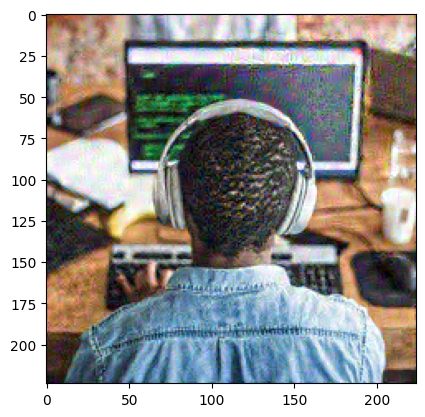

In [27]:
display_image(to_display)

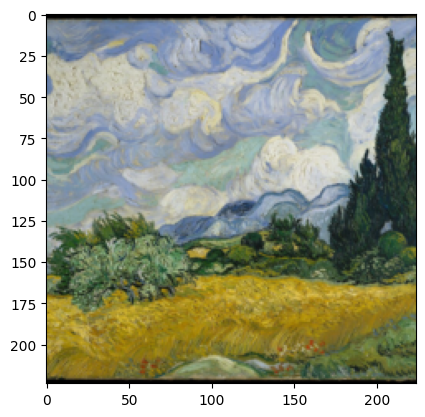

In [55]:
display_image(style_image)

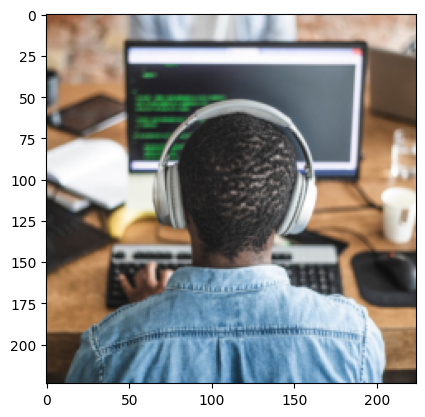

In [54]:
display_image(content_image)

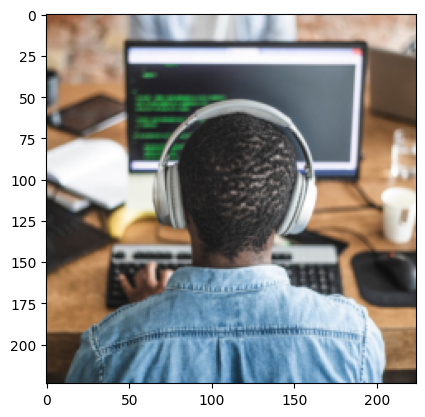

In [50]:
display_image(images[0])

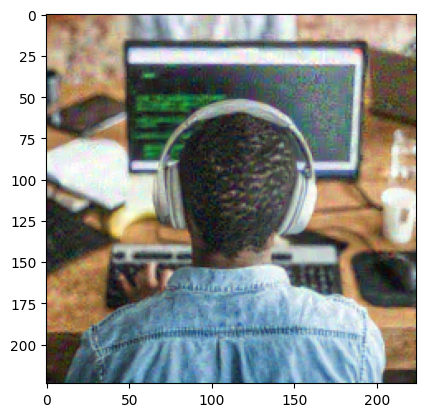

In [51]:
display_image(images[1])

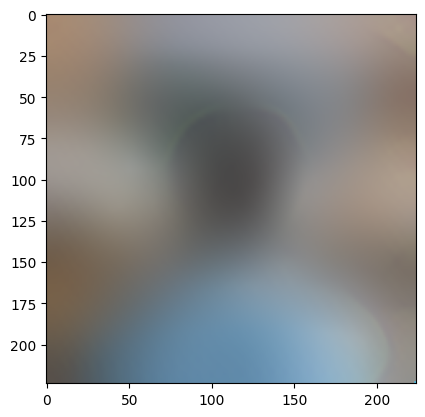

In [35]:
display_image(images[2])

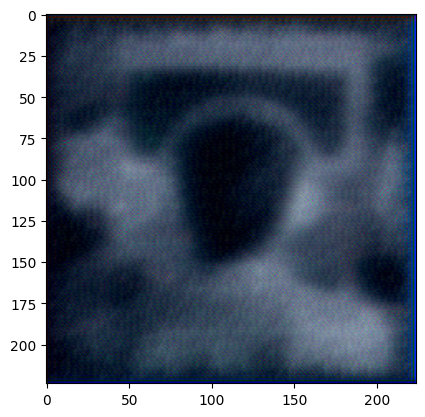

In [171]:
display_image(images[3])

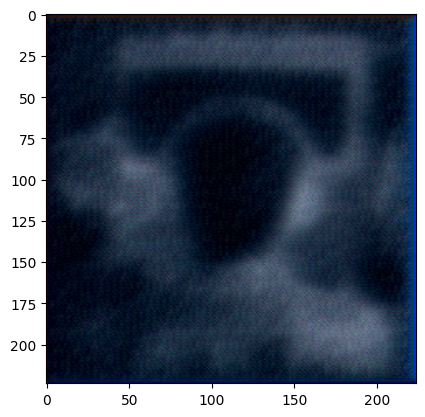

In [172]:
display_image(images[4])

In [158]:
loss.shape

torch.Size([])

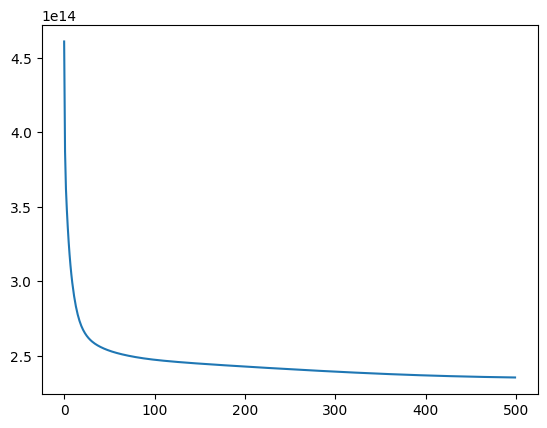

In [157]:
cop = [l.detach().clone() for l in losses]
plt.plot(cop)

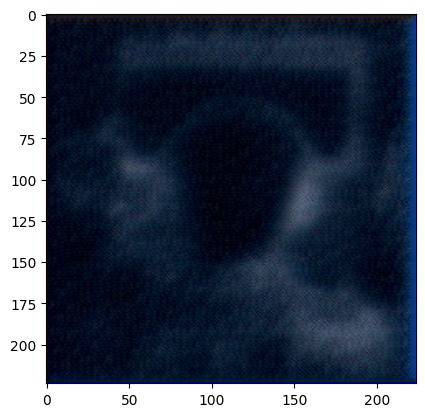

In [155]:
display_image(copied_image)

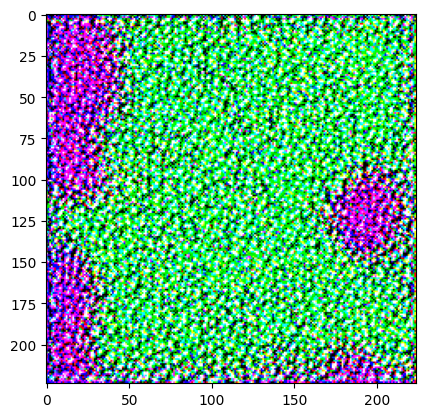

In [152]:
# Image from first iteration- forgot to zero out gradients on the loss
display_image(copied_image)

In [140]:
output_image.grad.reshape(1,-1)[0][:4]

tensor([ 0.0095,  0.0249, -0.0016,  0.0309])

In [129]:
loss = 0

x = 0
for i in style_layers:
    current_features = features[i]

    x += 1

for i in content_layers:
    current_features = features[i]
    x += 1

#     loss += loss_fns[i](current_features)
#     prin()
#     print(current_features.shape)
    
    
# for loss_fn in loss_fns:

#     loss += loss_fn(features)

In [122]:
loss.backward()

AttributeError: 'int' object has no attribute 'backward'

In [123]:
# output_image.grad.shape